In [1]:
import sys
sys.path.append(r"C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages")
import os
from pathlib import Path
import json
import random
import numpy as np
import spacy


from tqdm import tqdm
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from spacy.language import Language
from luima_sbd import sbd_utils as luima
import seaborn as sns
import plotly.express as px
import math
%matplotlib inline

# Phase 3.1: Splitting the unlabeled data

In [2]:
UNLABELED_DATA_PATH = Path("../Data/ldsi_w2021-20220221T223611Z-001/ldsi_w2021/unlabeled/unlabeled")
files = sorted(os.listdir(UNLABELED_DATA_PATH))
len(files)

30000

In [3]:
test_file = open(UNLABELED_DATA_PATH/ Path('0603946.txt'), 'r').read().encode('latin-1', 'ignore')
test_file = test_file.decode('latin-1').strip()
len(luima.text2sentences(test_file, offsets=False))

134

In [4]:
test_file = open(UNLABELED_DATA_PATH/ Path('0603946.txt'), 'r').read()
arr = bytes(test_file, 'utf-8')
arr = arr.decode('latin-1').strip()
len(luima.text2sentences(arr, offsets=False))

135

In [5]:
# unlab_segments_by_doc = []
# for file in tqdm(files):
#     text = open(UNLABELED_DATA_PATH/file).read()
#     byte_text = bytes(text, 'utf-8')
#     text = byte_text.decode('latin-1').strip()
    
#     doc = luima.text2sentences(text, offsets=False)
    
#     seg_data = {
#         'doc_name': file,
#         'no_of_sentences': len(doc),
# #         'sentences': doc
#     }
#     unlab_segments_by_doc.append(seg_data)

# import pickle
# with open(Path('../Data/')/'unlab_segments_by_doc', 'wb') as handle:
#     pickle.dump(unlab_segments_by_doc, handle)

# total_sentences = 0
# for seg in unlab_segments_by_doc:
#     total_sentences += seg['no_of_sentences']

In [6]:
import pickle
with open(Path('../Data/')/'unlab_segments_by_doc', 'rb') as handle:
    unlab_segments_by_doc = pickle.load(handle)

In [7]:
df = pd.DataFrame(unlab_segments_by_doc)
df.head()

,doc_name,no_of_sentences
0,0600090.txt,127
1,0600091.txt,117
2,0600134.txt,45
3,0600163.txt,131
4,0600177.txt,61


##### Plotting with Plotly

In [8]:
# bin_width= 0.5
# # here you can choose your rounding method, I've chosen math.ceil
# nbins = math.ceil((df["no_of_sentences"].max() - df["no_of_sentences"].min()) / bin_width)
# fig = px.histogram(df, x="no_of_sentences", nbins=nbins,
#             width=1200, height=600,
#             labels={ # replaces default labels by column name
#                 "no_of_sentences": "Number of Sentences",
#             },
#             template="plotly_white")
# fig.update_yaxes(showgrid=True)
# fig.update_layout(title_text="Histogram of Number of Sentences in Each Document", title_x=0.5, font_size=18)
# fig.show()

##### Plotting with seaborn

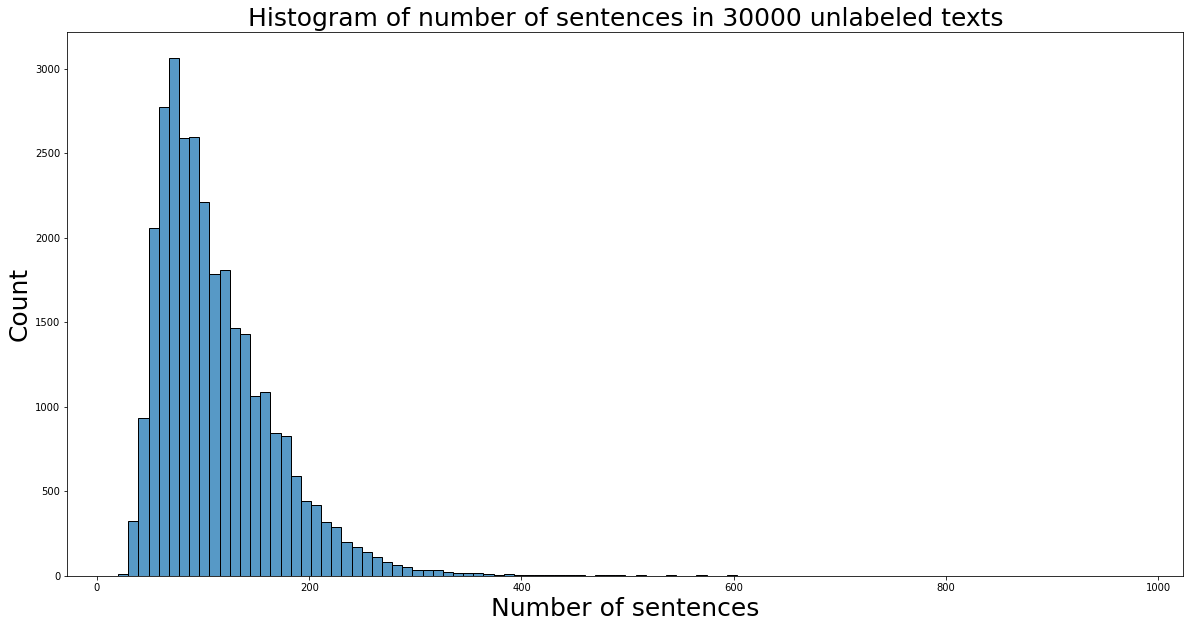

In [9]:
fig = plt.figure(figsize=(20, 10))
sns.histplot(data=df, x="no_of_sentences", bins=100)
plt.xlabel('Number of sentences', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.title('Histogram of number of sentences in 30000 unlabeled texts', fontsize=25)
plt.savefig('histogram of sentences with 100 bins.jpg')
plt.show()

##### Plotting with Matplotlib

In [10]:
# fig = plt.figure(figsize=(20, 10))
# plt.hist(df['no_of_sentences'], bins=100, color='royalblue')
# plt.title('Histogram of number of sentences in 30000 unlabeled texts', fontsize=25)
# plt.xlabel('Number of sentences', fontsize=25)
# plt.ylabel('Count', fontsize=25)
# # plt.savefig('histogram of sentences with 100 bins.jpg')
# plt.show()

# Phase 3.2: Sentence-wise preprocessing

### Tokenization

In [11]:
# def tokenize(txt):
#     dirty_tokens = re.split(' +', txt)  # split words
#     # remove all non-alphanumerics
#     clean_tokens = [re.sub(r'\W', '', t).lower() 
#                     for t in dirty_tokens]
#     if '' in clean_tokens:  # remove empty tokens
#         clean_tokens.remove('')
#     return clean_tokens


# def tokenize_spans(spans):
#     for s in spans:
#         s['tokens_manual'] = tokenize(s['txt'])
        
        
# def build_vocabulary(spans):
#     vocab_counts = {}
#     for sd in spans:
#         for t in tokenize(sd['txt']):
#             if t in vocab_counts:
#                 vocab_counts[t] += 1
#             else:
#                 vocab_counts[t] = 1
#     return vocab_counts

In [12]:
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
#         print(f'{t.text} | {t.lemma_} | {t.pos_}')
        if t.pos_ == 'PUNCT':
#             print(t)
            pass
#         if t.pos_ == 'PART' and re.search(r'\'', t.text):
#             print(f"Special case: {t}")
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_.lower())
#     if ',' in clean_tokens:
#         clean_tokens.remove()
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [13]:
def custom_spacy_tokenize_v2(txt):
    nlp.disable_pipes('parser')
    doc = nlp.pipe(txt, n_process=4)
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for i in range(len(tokens)):
        
        t=tokens[i]
        t1=tokens[i]
#         print(f'{t.text} | {t.lemma_} | {t.pos_}')
#         print(t.pos_, t.text)

#         if "-" in t.text:
#             splitted_t = t.text.split("-")
#             for i in range(len(splitted_t)):
#                 clean_tokens.append(splitted_t[i])
            
        if(i!=len(tokens)-1):
            t1=tokens[i+1]
        if(t1!=t and t1.pos_=='PART' and re.search(r'\'', t1.text)):
#             print(t, t1)
            scrap = t.text+t1.text
            scrap = re.sub(r'\W','',scrap).lower()
            clean_tokens.append(scrap)
            i=i+1           
        elif t.pos_ == 'PUNCT':
            pass
        elif t.text in ('Vet. App.','Fed. Cir.'):
            lem=t.lemma_
            lem=lem.lower()
            clean_tokens.append(lem)
        elif (t.text[0].isalpha()==False and t.is_digit==False):
            if(t.is_upper==False):
                pass
            else:
                lem=t.lemma_
                lem=lem.lower()
                clean_tokens.append(lem)            
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            lem=t.lemma_
            lem = re.sub(r'\W','',lem)
            lem=lem.lower()
            clean_tokens.append(lem)
            
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [14]:
a = "05/06/20"
re.search("^[0-9]{2}/[0-9]{2}/([0-9]{2}|[0-9]{4})$", a)

<re.Match object; span=(0, 8), match='05/06/20'>

In [15]:
def custom_spacy_tokenize(txt):
    nlp.disable_pipes('parser')
    doc = nlp.pipe(txt, n_process=4)
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for i, token in enumerate(tokens):
#         print(f"token: {token} | {token.pos_}")
        if token.pos_ == 'PUNCT' and not re.search("^[0-9]{2}/[0-9]{2}/([0-9]{2}|[0-9]{4})$", token.text):
            pass
        
        elif token.pos_ == 'NUM':
            refined_token = re.sub(r'\W', '', token.text)
            clean_tokens.append(f'<NUM{len(refined_token)}>')
            
        elif token.text == "\'s" and token.pos_ == 'PART':
            pos_token = tokens[i-1].text + token.text
            
            refined_token = re.sub(r'\W', '', pos_token.lower())
            
            if refined_token.isnumeric():
                refined_token = f'<NUM{len(refined_token)}>'
                
            if not refined_token == "":
                clean_tokens.append(pos_token.lower())
                clean_tokens.remove(tokens[i-1].text.lower())
                   
        elif "-" in token.text:
            splitted_tokens = token.text.split("-")

            for sp_token in splitted_tokens:
                refined_token = re.sub(r'\W', '', sp_token.lower())
                if refined_token != "":
                    if refined_token.isnumeric():
                        refined_token = f'<NUM{len(refined_token)}>'
                    clean_tokens.append(refined_token)
        elif token.text in ("Vet. App.", "Fed. Cir."):
            clean_tokens.append(token.lemma_.lower())
#         elif "." in token.text and token.text in ("Vet. App.", "Fed. Cir."):
#             print(f"Special condition fulfilled: {token.text}")
#             splitted_tokens = token.text.split(".")

#             for sp_token in splitted_tokens:
#                 refined_token = re.sub(r'\W', '', sp_token.lower())
#                 if refined_token != "":
#                     if refined_token.isnumeric():
#                         refined_token = f'<NUM{len(refined_token)}>'
#                     clean_tokens.append(refined_token)
        else:
            refined_token = re.sub(r'\W', '', token.lemma_.lower())
#             print(f"refined token: {refined_token}")
            if re.search('\d+', refined_token) and re.search('[a-zA-Z]+', refined_token):
#                 print("Matched mixed")
                continue
            elif refined_token != "" and refined_token.isnumeric():
#                 print("Matched digit only")
                refined_token = f'<NUM{len(refined_token)}>'
                clean_tokens.append(refined_token)

            elif refined_token != "":
#                 print(f"Nothing matched, inserting {refined_token}")
                clean_tokens.append(refined_token)
                    
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = custom_spacy_tokenize(s['txt'])

#### Testing Spacy tokenizer on some example sentences

In [16]:
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])

In [17]:
example_basic_1 = 'In sum, as the preponderance of the evidence is against the Veteran\'s claim, his appeal must be denied.'
example_cit_1 = 'Smith v. Gober, 14 Vet. App. 227 (2000), aff\'d 281 F.3d 1384 (Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).'
example_rule_1 = '"To establish a right to compensation for a present disability, a Veteran must show: "(1) the existence of a present disability; (2) in-service incurrence or aggravation of a disease or injury; and (3) a causal relationship between the present disability and the disease or injury incurred or aggravated during service"-the so-called "nexus" requirement."'
example_mixed_1 = 'In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded. '

In [18]:
print(example_basic_1, end="\n=============\n")
print(spacy_tokenize(example_basic_1 ), end="\n\n")
print(custom_spacy_tokenize(example_basic_1), end="\n\n")
print(custom_spacy_tokenize_v2(example_basic_1), end="\n\n")

In sum, as the preponderance of the evidence is against the Veteran's claim, his appeal must be denied.
['in', 'sum', 'as', 'the', 'preponderance', 'of', 'the', 'evidence', 'be', 'against', 'the', 'veteran', "'s", 'claim', 'his', 'appeal', 'must', 'be', 'deny']

['in', 'sum', 'as', 'the', 'preponderance', 'of', 'the', 'evidence', 'be', 'against', 'the', "veteran's", 'claim', 'his', 'appeal', 'must', 'be', 'deny']

['in', 'sum', 'as', 'the', 'preponderance', 'of', 'the', 'evidence', 'be', 'against', 'the', 'veterans', 'claim', 'his', 'appeal', 'must', 'be', 'deny']



In [19]:
print(example_cit_1, end="\n=============\n")
print(spacy_tokenize(example_cit_1 ), end="\n\n")
print(custom_spacy_tokenize(example_cit_1), end="\n\n")
print(custom_spacy_tokenize_v2(example_cit_1), end="\n\n")

Smith v. Gober, 14 Vet. App. 227 (2000), aff'd 281 F.3d 1384 (Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).
['smith', 'v.', 'gober', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', "aff'd", '<NUM3>', 'f.3d', '<NUM4>', 'fed. cir.', '<NUM4>', 'dela', 'cruz', 'v.', 'principi', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', 'see', 'also', 'quartuccio', 'v.', 'principi', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>']

['smith', 'v', 'gober', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', 'affd', '<NUM3>', '<NUM4>', 'fed. cir.', '<NUM4>', 'dela', 'cruz', 'v', 'principi', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', 'see', 'also', 'quartuccio', 'v', 'principi', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>']

['smith', 'v', 'gober', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', 'affd', '<NUM3>', 'f3d', '<NUM4>', 'fed. cir.', '<NUM4>', 'dela', 'cruz', 'v', 'principi', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', 'see', 'also', 'quartuccio', 'v', 

In [20]:
print(example_rule_1, end="\n=============\n")
print(spacy_tokenize(example_rule_1 ), end="\n\n")
print(custom_spacy_tokenize(example_rule_1), end="\n\n")
print(custom_spacy_tokenize_v2(example_rule_1), end="\n\n")

"To establish a right to compensation for a present disability, a Veteran must show: "(1) the existence of a present disability; (2) in-service incurrence or aggravation of a disease or injury; and (3) a causal relationship between the present disability and the disease or injury incurred or aggravated during service"-the so-called "nexus" requirement."
['to', 'establish', 'a', 'right', 'to', 'compensation', 'for', 'a', 'present', 'disability', 'a', 'veteran', 'must', 'show', '1', 'the', 'existence', 'of', 'a', 'present', 'disability', '2', 'in', 'service', 'incurrence', 'or', 'aggravation', 'of', 'a', 'disease', 'or', 'injury', 'and', '3', 'a', 'causal', 'relationship', 'between', 'the', 'present', 'disability', 'and', 'the', 'disease', 'or', 'injury', 'incur', 'or', 'aggravate', 'during', 'service"-the', 'so', 'call', 'nexus', 'requirement']

['to', 'establish', 'a', 'right', 'to', 'compensation', 'for', 'a', 'present', 'disability', 'a', 'veteran', 'must', 'show', '<NUM1>', 'the', '

In [21]:
print(example_mixed_1, end="\n=============\n")
print(spacy_tokenize(example_mixed_1 ), end="\n\n")
print(custom_spacy_tokenize(example_mixed_1), end="\n\n")
print(custom_spacy_tokenize_v2(example_mixed_1), end="\n\n")

In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded. 
['in', 'dingess', 'v.', 'nicholson', '<NUM2>', 'vet. app.', '<NUM3>', '<NUM4>', 'the', 'u.s.', 'court', 'of', 'appeals', 'for', 'veterans', 'claims', 'hold', 'that', 'upon', 'receipt', 'of', 'an', 'application', 'for', 'a', 'service', 'connection', 'claim', '<NUM2>', 'u.s.c.a.', '�', '<NUM6>', 'and', '<NUM2>', 'c.f.r.', '�', '3.159(b', 'require', 'va', 'to', 'provide', 'the', 'claimant', 'with', 'notice', 'that', 'a', 'disability', 'rating', 'and', 'an', 'effective', 'date', 'for', 'the', 'award', 'of', 'benefit', 'will', 'be', 'assign', 'if', 'service', 'connection', 'be', 'award']

['in', 'dingess', 'v

In [22]:
sp_text_1 = "38 C.F.R. § 3.303(d) (2005)."

print(sp_text_1, end="\n=============\n")
print(spacy_tokenize(sp_text_1 ), end="\n\n")
print(custom_spacy_tokenize(sp_text_1), end="\n\n")
print(custom_spacy_tokenize_v2(sp_text_1), end="\n\n")

38 C.F.R. § 3.303(d) (2005).
['<NUM2>', 'c.f.r.', '§', '3.303(d', '<NUM4>']

['<NUM2>', 'cfr', '<NUM4>']

['<NUM2>', 'cfr', '<NUM4>']



In [23]:
sp_text_2 = "BOARD OF VETERANS APPEALS\nDEPARTMENT OF VETERANS AFFAIRS\nWASHINGTON, DC  20420"

print(sp_text_2, end="\n=============\n")
print(spacy_tokenize(sp_text_2 ), end="\n\n")
print(custom_spacy_tokenize(sp_text_2), end="\n\n")
print(custom_spacy_tokenize_v2(sp_text_2), end="\n\n")

BOARD OF VETERANS APPEALS
DEPARTMENT OF VETERANS AFFAIRS
WASHINGTON, DC  20420
['board', 'of', 'veterans', 'appeals', '\n', 'department', 'of', 'veterans', 'affairs', '\n', 'washington', 'dc', ' ', '<NUM5>']

['board', 'of', 'veterans', 'appeals', 'department', 'of', 'veterans', 'affairs', 'washington', 'dc', '<NUM5>']

['board', 'of', 'veterans', 'appeals', 'department', 'of', 'veterans', 'affairs', 'washington', 'dc', '<NUM5>']



In [24]:
sp_text_3 = "X-rays demonstrated \nminimal degenerative changes at the L5-S1."

print(sp_text_3, end="\n=============\n")
print(spacy_tokenize(sp_text_3 ), end="\n\n")
print(custom_spacy_tokenize(sp_text_3), end="\n\n")
print(custom_spacy_tokenize_v2(sp_text_3), end="\n\n")

X-rays demonstrated 
minimal degenerative changes at the L5-S1.
['x', '-', 'ray', 'demonstrate', '\n', 'minimal', 'degenerative', 'change', 'at', 'the', 'l5', 's1']

['x', 'ray', 'demonstrate', 'minimal', 'degenerative', 'change', 'at', 'the']

['x', 'ray', 'demonstrate', 'minimal', 'degenerative', 'change', 'at', 'the', 'l5', 's1']



In [25]:
sp_txt_4 = "Spacy's tokenizer requires special rules for producing 'state-of-the-art' tokens."

print(sp_txt_4, end="\n=============\n")
print(spacy_tokenize(sp_txt_4 ), end="\n\n")
print(custom_spacy_tokenize(sp_txt_4), end="\n\n")
print(custom_spacy_tokenize_v2(sp_txt_4), end="\n\n")

Spacy's tokenizer requires special rules for producing 'state-of-the-art' tokens.
['spacy', "'s", 'tokenizer', 'require', 'special', 'rule', 'for', 'produce', 'state', 'of', 'the', 'art', 'token']

["spacy's", 'tokenizer', 'require', 'special', 'rule', 'for', 'produce', 'state', 'of', 'the', 'art', 'token']

['spacys', 'tokenizer', 'require', 'special', 'rule', 'for', 'produce', 'state', 'of', 'the', 'art', 'token']



In [26]:
sp_txt_5 = "C.F.R. §§ 3.102, 3.303, 3.306, 3.310 (2005)."

print(sp_txt_5, end="\n=============\n")
print(spacy_tokenize(sp_txt_5 ), end="\n\n")
print(custom_spacy_tokenize(sp_txt_5), end="\n\n")
print(custom_spacy_tokenize_v2(sp_txt_5), end="\n\n")

C.F.R. §§ 3.102, 3.303, 3.306, 3.310 (2005).
['c.f.r.', '§', '§', '<NUM5>', '<NUM5>', '<NUM5>', '<NUM5>', '<NUM4>']

['cfr', '<NUM4>', '<NUM4>', '<NUM4>', '<NUM4>', '<NUM4>']

['cfr', '<NUM4>']



In [27]:
sp_text_6 = "Decision Date: 03/08/06"

print(sp_text_6, end="\n=============\n")
print(spacy_tokenize(sp_text_6 ), end="\n\n")
print(custom_spacy_tokenize(sp_text_6), end="\n\n")
print(custom_spacy_tokenize_v2(sp_text_6), end="\n\n")

Decision Date: 03/08/06
['decision', 'date']

['decision', 'date', '<NUM6>']

['decision', 'date']



In [28]:
sp_text_7 = "Archive Date: 06/16/06"

print(sp_text_7, end="\n=============\n")
print(spacy_tokenize(sp_text_7 ), end="\n\n")
print(custom_spacy_tokenize(sp_text_7), end="\n\n")
print(custom_spacy_tokenize_v2(sp_text_7), end="\n\n")

Archive Date: 06/16/06
['archive', 'date', '<NUM8>']

['archive', 'date', '<NUM6>']

['archive', 'date']



### Test the tokenization of a single file

In [29]:
test_file = open(UNLABELED_DATA_PATH/ Path('0603946.txt'), 'r').read().encode('latin-1', 'ignore')
test_file = test_file.decode('latin-1').strip()
doc = luima.text2sentences(test_file, offsets=False)

spans = [{'txt': sent} for sent in doc]
spans_add_spacy_tokens(spans)

In [30]:
# token_save_file = 'tokenized_sentences_unlabeled.txt'
# file = open(token_save_file, 'w')
# dir(file)

In [34]:
token_save_file = 'tokenized_sentences_unlabeled.txt'
file = open(token_save_file, 'a')

for i, span in enumerate(spans):
    for pos, token in enumerate(span['tokens_spacy']):
        if pos == 0:
            file.write(token)
        else:
            file.write(" " + token)
        
    file.write("\n")
#     print(f"{i+1}. {span['txt'].ljust(len(span['txt']))} | {span['tokens_spacy']}", end="\n\n")

In [ ]:
tokenize_spans(spans)

In [ ]:
for span in spans:
    print(span, end="\n\n")

In [ ]:
spacy_tokenize(example_cit_1)

In [ ]:
tokenize(example_cit_1)